# BM25 & TF-IDF: Complete Summary


## TF-IDF Fundamentals

### What is TF-IDF?

TF-IDF (Term Frequency–Inverse Document Frequency) measures how important a word is to a document in a collection.

**Formula:** `TF-IDF = TF × IDF`

| Component | Definition | Intuition |
|-----------|------------|----------|
| **TF** (Term Frequency) | How often the word appears in *this* document | More occurrences → higher score |
| **IDF** (Inverse Document Frequency) | How rare the word is across *all* documents | Rarer words → higher score |

> **Interview-ready:** "TF-IDF scores a word high when it's frequent in the current document AND rare overall."

### Why Log for IDF?

**Problem:** Without log, rare words get extreme scores (e.g., 10,000 for a word in 1 of 10,000 docs).

**Solution:** Log compresses large ratios.

> **Sticky analogy:** "Being the *only* person in town with a rare skill is distinctive. But 1,000 vs 1,001 people knowing it? Barely matters."

Log captures **diminishing returns**: the jump from 1→2 docs matters more than 1000→1001 docs.

In [ ]:
import math

raw_idf = 10000 / 1        # 10000
log_idf = math.log(10000)  # ~9.21

print(f"Raw IDF: {raw_idf}")
print(f"Log IDF: {log_idf:.2f}")

Raw IDF: 10000.0
Log IDF: 9.21


### TF-IDF Worked Example

**Documents:**
- Doc 1: "cat cat dog"
- Doc 2: "dog bird"

**Step 1: Term Frequency (TF)**

| Doc | "cat" | "dog" | "bird" |
|-----|-------|-------|--------|
| Doc 1 | 2/3 ≈ 0.67 | 1/3 ≈ 0.33 | 0 |
| Doc 2 | 0 | 1/2 = 0.5 | 1/2 = 0.5 |

**Step 2: Inverse Document Frequency (IDF)**

Formula: `IDF(t) = log(N / df_t)` where N = total docs, df = docs containing term

| Term | Calculation | IDF |
|------|-------------|-----|
| "cat" | log(2/1) | 0.69 |
| "dog" | log(2/2) | 0 (in both!) |
| "bird" | log(2/1) | 0.69 |

**Step 3: TF-IDF = TF × IDF**

| Doc | "cat" | "dog" | "bird" |
|-----|-------|-------|--------|
| Doc 1 | 0.67 × 0.69 = **0.46** | 0.33 × 0 = **0** | — |
| Doc 2 | — | 0.5 × 0 = **0** | 0.5 × 0.69 = **0.35** |

> **Key insight:** "dog" gets zero because it's in every document—it's not distinctive!

---

## BM25: Improvements Over TF-IDF

### Why BM25 is Better

| Problem with TF-IDF | BM25 Solution |
|---------------------|---------------|
| Term frequency grows linearly (10 mentions = 10× score) | **Saturation**: after a point, more mentions don't help much |
| No document length consideration | **Length normalization**: penalizes long docs that might score higher just by having more words |

> **Interview-ready:** "BM25 improves TF-IDF by adding term frequency saturation and document length normalization."

### BM25 Term Frequency Formula

```
(freq × (k1 + 1)) / (freq + k1)
```

**Why this works:**
- As freq grows, both numerator and denominator grow at nearly the same rate
- The `+ k1` in denominator acts as a "brake"
- **Limit:** As freq → ∞, formula approaches `k1 + 1`

In [ ]:
def bm25_tf(freq, k1=1.5):
    """BM25 term frequency component"""
    return (freq * (k1 + 1)) / (freq + k1)

# Compare TF-IDF vs BM25 as frequency increases
print("freq  TF-IDF  BM25")
print("-" * 20)
for f in [1, 2, 5, 10, 20, 50]:
    tfidf_score = f
    bm25_score = bm25_tf(f)
    print(f"{f:3d}   {tfidf_score:3d}     {bm25_score:.3f}")

freq  TF-IDF  BM25
--------------------
  1     1     1.000
  2     2     1.429
  5     5     1.923
 10    10     2.174
 20    20     2.326
 50    50     2.427


### Saturation Visualization

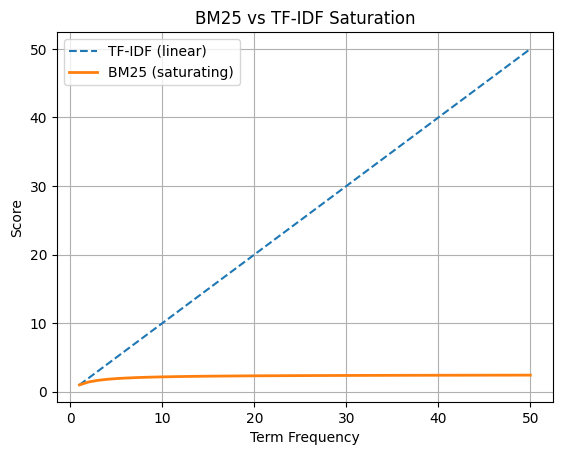

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

freq = np.arange(1, 51)
bm25_scores = bm25_tf(freq, k1=1.5)
tfidf_scores = freq

plt.plot(freq, tfidf_scores, label='TF-IDF (linear)', linestyle='--')
plt.plot(freq, bm25_scores, label='BM25 (saturating)', linewidth=2)
plt.xlabel('Term Frequency')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.title('BM25 vs TF-IDF Saturation')
plt.show()

> **Sticky analogy (Saturation):** "The first slice of pizza is amazing, the second is great, but by the 10th slice... you're not getting much extra satisfaction!"

---

## BM25 Parameters: The Two Knobs

### Overview Table

| Parameter | Intuitive Name | Analogy | Default |
|-----------|----------------|---------|--------|
| **k1** | "Stop counting obsessively" | **Patience** — how long we keep listening to repetition | 1.5 |
| **b** | "Don't reward rambling" | **Tax** — penalty on long documents | 0.75 |

> **Interview-ready:** "k1 controls term frequency saturation (patience with repetition), b controls document length normalization (tax on long docs)."

### Parameter k1: "Stop Counting Obsessively" (Patience)

**What it controls:** How quickly we stop caring about repeated mentions.

| Direction | Effect |
|-----------|--------|
| **Higher k1** | More patience → saturation slower → repetition keeps mattering longer |
| **Lower k1** | Less patience → saturation faster → stop rewarding spam quickly |

> **Analogy:** "Higher patience = you listen longer before tuning out."

### Parameter b: "Don't Reward Rambling" (Tax)

**What it controls:** How much we penalize document length.

| Direction | Effect |
|-----------|--------|
| **Higher b** | More tax → penalize long docs more → short focused docs rank better |
| **Lower b** | Less tax → long comprehensive docs can rank better |

> **Analogy:** "Higher tax = you pay more for being long."

> **Sticky phrase:** "Density matters, not just count" — a short article that's 10% about cats is more focused than a long book that mentions cats the same number of times.

### Visualization of Both Parameters

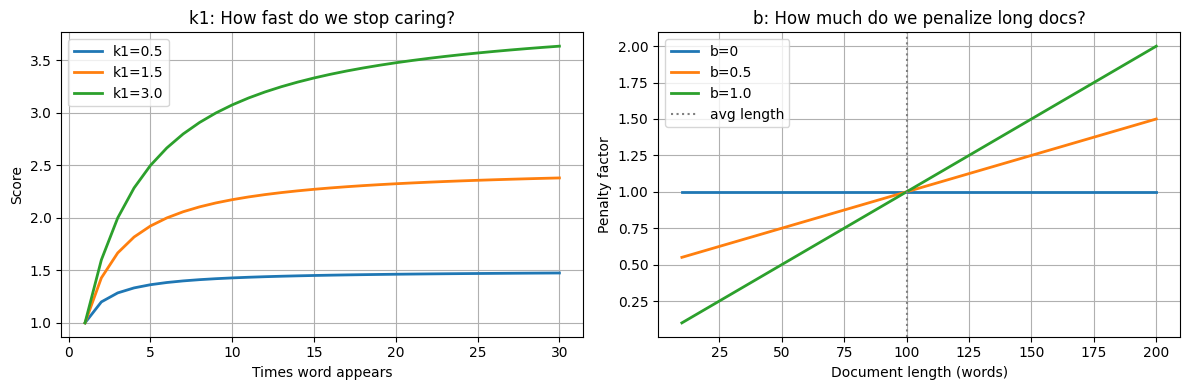

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

freq = np.arange(1, 31)

# Plot 1: k1 effect
for k1 in [0.5, 1.5, 3.0]:
    scores = (freq * (k1 + 1)) / (freq + k1)
    axes[0].plot(freq, scores, label=f'k1={k1}', linewidth=2)

axes[0].set_xlabel('Times word appears')
axes[0].set_ylabel('Score')
axes[0].set_title('k1: How fast do we stop caring?')
axes[0].legend()
axes[0].grid(True)

# Plot 2: b effect (document length)
doc_lengths = np.linspace(10, 200, 50)
avg_len = 100

for b in [0, 0.5, 1.0]:
    penalty = 1 - b + b * (doc_lengths / avg_len)
    axes[1].plot(doc_lengths, penalty, label=f'b={b}', linewidth=2)

axes[1].axvline(x=100, color='gray', linestyle=':', label='avg length')
axes[1].set_xlabel('Document length (words)')
axes[1].set_ylabel('Penalty factor')
axes[1].set_title('b: How much do we penalize long docs?')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

---

## Tuning Guide: Quick Reference

| Problem | Which knob? | Direction | Analogy |
|---------|-------------|-----------|----------|
| Keyword stuffing/spam | k1 | ↓ Decrease | Less patience |
| Long docs always winning | b | ↑ Increase | More tax |
| Short docs always winning | b | ↓ Decrease | Less tax |
| Repetition rewarded too much | k1 | ↓ Decrease | Less patience |

---

## Scenario-Based Examples

### Example 1: Customer Support Tickets

**Problem:** Angry customers who repeat "WRONG wrong wrong!" rank too high; short professional tickets rank too low.

**Solution:**
- Lower k1 (less patience) → stop rewarding repetition
- Higher b (more tax) → penalize rambling complaints

### Example 2: Recipe Search

**Problems:**
1. "garlic garlic garlic" spam ranks too high
2. Long recipes with backstories dominate

**Solution:**
- Lower k1 (less patience) → stop keyword stuffing
- Higher b (more tax) → penalize verbose recipes

### Example 3: Legal Documents (Tricky!)

**Problems:**
1. Short emails beat comprehensive 100-page legal briefs
2. Some papers spam keywords 200 times

**Solution:**
- Lower b (less tax) → let comprehensive docs compete
- Lower k1 (less patience) → stop keyword spam

### Example 4: Medical Research (Advanced!)

**Problems:**
1. Short 1-page pamphlets beat 100-page clinical studies
2. Low-quality papers spam keywords in references
3. Short focused abstracts (200 words) should still rank well

**Solution:**
- Lower b (less tax) → helps BOTH short abstracts AND long studies against medium-length pamphlets
- Lower k1 (less patience) → stops keyword spam

> **Key insight:** "Lowering tax doesn't just help long docs—it helps any document being unfairly compared to 'medium' length winners."

---

## Practical Implementation

In [ ]:
from langchain_community.retrievers import BM25Retriever

# Sample documents
docs = [
    "The cat sat on the mat",
    "The dog ran in the park", 
    "Cats and dogs are popular pets",
    "The mat was red and fluffy"
]

# Create retriever with custom parameters
retriever = BM25Retriever.from_texts(docs, k=2)

# Adjust BM25 parameters
retriever.vectorizer.k1 = 1.2  # Less patience (faster saturation)
retriever.vectorizer.b = 0.8   # More tax (penalize long docs more)

# Query
results = retriever.invoke("cat on mat")
for r in results:
    print(r.page_content)

The cat sat on the mat
The mat was red and fluffy


---

## Limitations & Trade-offs

1. **No universal perfect values** — tuning depends entirely on your corpus and use case
2. **Mixed corpus challenge** — if you have tweets AND legal documents, one setting won't fit both
3. **Empirical tuning required** — start with defaults, test, observe, adjust

**Practitioner strategies:**
- Start with defaults (k1=1.5, b=0.75)
- Tune empirically based on search result quality
- Segment corpus by document type if needed
- Use relevance feedback from users

---

## Quick Reference Card

### TF-IDF
- **TF** = word count in document
- **IDF** = log(total docs / docs with term)
- **Problem**: Linear TF, no length normalization

### BM25 Parameters

| | k1 | b |
|---|---|---|
| **Name** | "Stop counting obsessively" | "Don't reward rambling" |
| **Analogy** | Patience | Tax |
| **Default** | 1.5 | 0.75 |
| **↑ Increase** | More patience with repetition | More penalty for length |
| **↓ Decrease** | Stop caring about repetition sooner | Less penalty for length |

### Sticky Analogies

| Concept | Analogy |
|---------|--------|
| TF saturation | Pizza slices — 10th slice doesn't add much |
| Log in IDF | Being unique in town vs 1000 vs 1001 people |
| k1 | Patience — how long before tuning out |
| b | Tax — penalty you pay for being long |
| Document length normalization | "Don't reward rambling" |
| Term frequency saturation | "Stop counting obsessively" |

In [ ]:
#| hide

import subprocess
from pathlib import Path
from dialoghelper import curr_dialog

def deploy_notebook():
    nb_name = Path(curr_dialog()['name']).name + '.ipynb'
    src = f'/app/data/{curr_dialog()["name"]}.ipynb'
    dst = '/app/data/publish/portfolio/static/'
    print(nb_name)
    
    # Copy notebook to static folder
    subprocess.run(['cp', src, dst])
    
    # Deploy with plash
    subprocess.run(['plash_deploy'], cwd='/app/data/publish/portfolio')

In [ ]:
#| hide
deploy_notebook()